# Auxiliar Classifier Generative Advarsarial Network

Here is presented the implementation of the following parper https://arxiv.org/abs/1610.09585

This work is similar to the conditional GAN but now besides the discriminator there is a classifier.

Implementation is done in tensorflow using layers API

Created by: Tiago Almeida 05/02/2018


In [1]:
##### imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data mnist

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


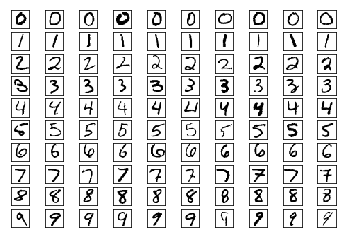

In [2]:


mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data",one_hot=True)


#ut.plot_mnist_images(mnist.test.images[0:9])

#reset graph using during notebook development
#tf.reset_default_graph()
images_per_class = 10
images = np.zeros((10*images_per_class,mnist_flat_size))
for l in range(10):
    images[(l*images_per_class):(l*images_per_class+images_per_class)] = mnist.test.images[(ut.max_row_index(mnist.test.labels)==l)][:images_per_class]
    
ut.plot_mnist_images_conditonal(images,per_class = images_per_class)

#### Code parameters

In [3]:
z_dimention = 100

#array that contain the network dimention at least 3 dimention (input, hidden and output dimentions)
G_dimentions = [z_dimention,128,mnist_flat_size]
D_dimentions = [mnist_flat_size,128,1] ##ouput fake, true
C_dimentions = [mnist_flat_size,256,128,10] 

batch_size = 128
epoach = 10000

### Generator network

In [4]:

Z = tf.placeholder(tf.float32, shape=[None, G_dimentions[0]], name='x_generator_input')
Y = tf.placeholder(tf.float32, shape=[None, 10], name='number_label')

def generator(x,y):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :param y: tensor with shape (M,10) labels in one hot encoder
    :return: tensor with shape (M,784) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.name_scope("generator_nn"):

        he_init = tf.contrib.layers.variance_scaling_initializer()
        
        concat_input = tf.concat([x, y], 1)
        
        g_net = tf.layers.dense(concat_input,G_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='g_hidden1',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        for i in range(2,len(G_dimentions)-1):#loop throw hidden layers
            g_net = tf.layers.dense(g_net,G_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='g_hidden'+str(i),reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        g_net = tf.layers.dense(g_net,G_dimentions[-1],activation=tf.nn.sigmoid,name='g_output',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        return g_net


### Discriminator Network

In [5]:

X = tf.placeholder(tf.float32, shape=[None, D_dimentions[0]], name='x_discriminator_input')

def discriminator(x,y):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,784) here M = number of samples
    :param y: tensor with shape (10,1) labels in one hot encoder
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.name_scope("discriminator_nn"):
        he_init = tf.contrib.layers.variance_scaling_initializer()
        concat_input = tf.concat([x, y], 1)
        
        d_net = tf.layers.dense(concat_input,D_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='d_hidden1',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        for i in range(2,len(D_dimentions)-1):#loop throw hidden layers
            d_net = tf.layers.dense(d_net,D_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='d_hidden'+str(i),reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        d_net = tf.layers.dense(d_net,D_dimentions[-1],activation=None,name='d_output',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        #save the logits before the sigmoid activation (ouput between[0,1]) for alternative loss function
        d_logits = d_net
        d_net = tf.nn.sigmoid(d_net)
        return d_net,d_logits

### Classifier Network

In [6]:
def classifier(x):
    '''
    Classifier implemented as MLP
    
    :param x: tensor with shape (M,784) here M = number of samples
    :return: tensor with shape (M,10) corresponding to the probability of each class
    '''
    with tf.name_scope("classifier_nn"):
        he_init = tf.contrib.layers.variance_scaling_initializer()
        
        c_net = tf.layers.dense(x,C_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='c_hidden1',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        for i in range(2,len(C_dimentions)-1):#loop throw hidden layers
            c_net = tf.layers.dense(c_net,C_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='c_hidden'+str(i),reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        c_net = tf.layers.dense(c_net,C_dimentions[-1],activation=None,name='c_output',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        #save the logits before the sigmoid activation (ouput between[0,1]) for alternative loss function
        c_logits = c_net
        c_net = tf.nn.softmax(c_net)
        return c_net,c_logits

### Loss functions

In [7]:
#using now the xentropy (TODO use the default)
generated_sample = generator(Z,Y)
d_fake_prob, d_fake_logits = discriminator(generated_sample,Y) #D(G(Z|Y)|Y)
c_fake_class, c_fake_logits = classifier(generated_sample)

d_true_prob, d_true_logits = discriminator(X,Y)
c_true_class, c_true_logits = classifier(X)
alternative_loss = True

eps = 1e-8

def xentropy_softmax(logits,labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

def xentropy_sigmoid(logits,labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

with tf.name_scope("class_loss"):
    class_loss = xentropy_softmax(c_true_logits,Y) + xentropy_softmax(c_fake_logits,Y)

with tf.name_scope("discriminator_loss"):
    if alternative_loss:
        d_loss_gan = xentropy_sigmoid(d_true_logits,tf.ones_like(d_true_logits)) + xentropy_sigmoid(d_fake_logits,tf.zeros_like(d_fake_logits)) 
    else:
        d_loss_gan = -tf.reduce_mean(tf.log(d_true_prob + eps) + tf.log(1. - d_fake_prob + eps))
    d_loss = (d_loss_gan + class_loss)#to be maximize sorce_loss + class_loss so with minimeze the negative

with tf.name_scope("generator_loss"):
    if alternative_loss:
        g_loss_gan = xentropy_sigmoid(d_fake_logits, tf.ones_like(d_fake_logits))
    else:
        g_loss_gan = -tf.reduce_mean(tf.log(d_fake_prob + eps))
    g_loss =  (g_loss_gan + class_loss)
    

### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

In [8]:
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if ('d_' in var.name or 'c_' in var.name)]

# kernel = weight
print(generator_variables)
print(discriminator_variables)

[<tf.Variable 'g_hidden1/kernel:0' shape=(110, 128) dtype=float32_ref>, <tf.Variable 'g_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'g_output/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'g_output/bias:0' shape=(784,) dtype=float32_ref>]
[<tf.Variable 'd_hidden1/kernel:0' shape=(794, 128) dtype=float32_ref>, <tf.Variable 'd_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'd_output/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'd_output/bias:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'c_hidden1/kernel:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'c_hidden1/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'c_hidden2/kernel:0' shape=(256, 128) dtype=float32_ref>, <tf.Variable 'c_hidden2/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'c_output/kernel:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'c_output/bias:0' shape=(10,) dtype=float32_ref>]


### Train

Epoach 0
Discriminator loss:  6.12442
Generator loss: 7.70742


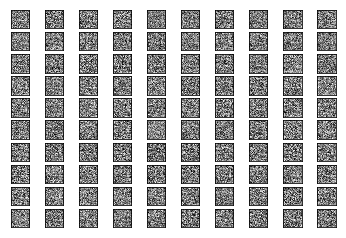

Epoach 1000
Discriminator loss:  0.302562
Generator loss: 6.47817


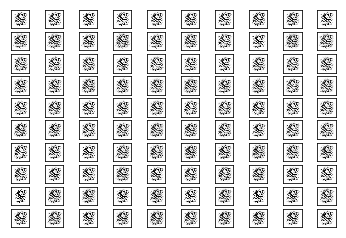

Epoach 2000
Discriminator loss:  0.168831
Generator loss: 4.68332


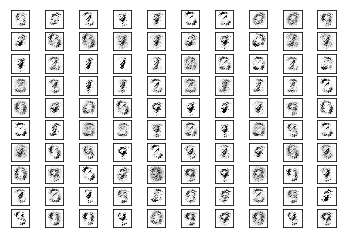

Epoach 3000
Discriminator loss:  0.247835
Generator loss: 4.7646


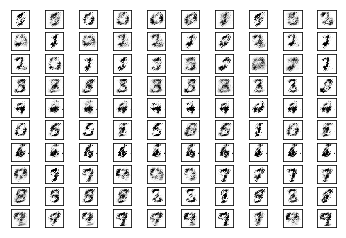

Epoach 4000
Discriminator loss:  0.291204
Generator loss: 4.94342


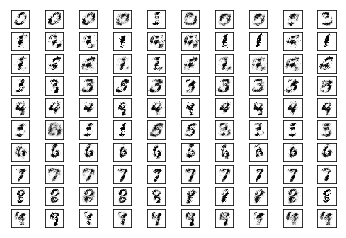

Epoach 5000
Discriminator loss:  0.499663
Generator loss: 5.01613


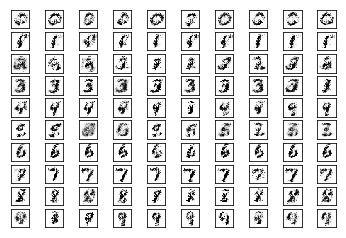

Epoach 6000
Discriminator loss:  0.394289
Generator loss: 3.92432


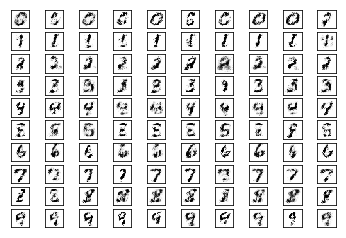

Epoach 7000
Discriminator loss:  0.534168
Generator loss: 3.75964


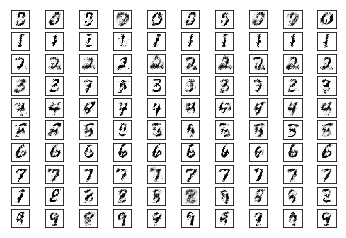

Epoach 8000
Discriminator loss:  0.664745
Generator loss: 3.40341


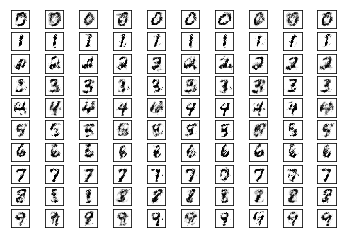

Epoach 9000
Discriminator loss:  0.933131
Generator loss: 2.6478


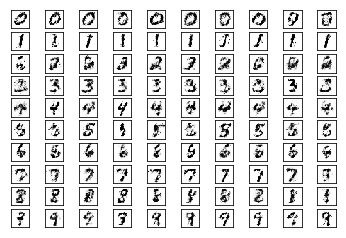

Epoach 10000
Discriminator loss:  0.74177
Generator loss: 2.96678


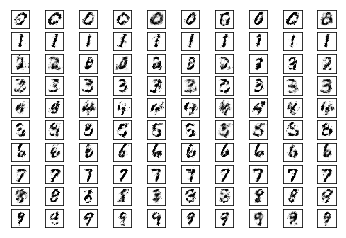

In [9]:
lr=0.001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


## Start graph computations and algorithm

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach+1):
    x_train,y_train = mnist.train.next_batch(batch_size)
    
    #print(y_one_hot)
    #first discriminator
    _, d_loss_value = sess.run([d_train_op, d_loss], feed_dict={X: x_train, Y:y_train , Z: ut.random_Z(batch_size,n=z_dimention)})
    #second generator
    _, g_loss_value = sess.run([g_train_op, g_loss], feed_dict={Z: ut.random_Z(batch_size,n=z_dimention),Y:y_train,X: x_train})

    if i%1000 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)
        
        #visual progress of training
        z_new = ut.random_Z(images_per_class*10,n=z_dimention)
                
        conditional_y = ut.one_hot(np.repeat(list(range(10)), images_per_class))
        
        generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new,Y:conditional_y})
        ut.plot_mnist_images_conditonal(generated_images,per_class = images_per_class)

### Testing the classifier

In [10]:
accuracy_clf = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(c_true_logits, 1), tf.argmax(Y, 1)), tf.float32))

acc = sess.run([accuracy_clf], feed_dict={X: mnist.test.images,Y:mnist.test.labels})
print("acc",acc)

acc [0.97500002]


In [11]:
sess.close()